In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/titanic\titanic.ipynb
/kaggle/titanic\data\gender_submission.csv
/kaggle/titanic\data\test.csv
/kaggle/titanic\data\train.csv


#### Read CSV

In [3]:
df_train_o = pd.read_csv('/kaggle/titanic/data/train.csv')
df_test_o = pd.read_csv('/kaggle/titanic/data/test.csv')

In [4]:
df_train_o

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [28]:
df_test_o

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


#### Embarked: Port of Embarkation

#### Get the number of NULL in train set

In [5]:
df_train_o.isnull().sum(axis = 0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df_test_o.isnull().sum(axis = 0)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Drop PassengerId, Name (irrelvant), Cabin (too many NULL) 

In [7]:
df_train = df_train_o.drop(columns=['PassengerId', 'Cabin','Name'])
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,S
887,1,1,female,19.0,0,0,112053,30.0000,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,S
889,1,1,male,26.0,0,0,111369,30.0000,C


In [8]:
df_train.isnull().sum(axis = 0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
dtype: int64

In [9]:
df_train.mode()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0.0,3.0,male,24.0,0.0,0.0,1601,8.05,S
1,NaN,NaN,NaN,NaN,NaN,NaN,347082,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,CA. 2343,NaN,NaN


In [10]:
df_train.mean()

<ipython-input-10-9f4e3ea3a1c4>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train.mean()


Survived     0.383838
Pclass       2.308642
Age         29.699118
SibSp        0.523008
Parch        0.381594
Fare        32.204208
dtype: float64

In [11]:
df_train.median()

<ipython-input-11-3d119a650328>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_train.median()


Survived     0.0000
Pclass       3.0000
Age         28.0000
SibSp        0.0000
Parch        0.0000
Fare        14.4542
dtype: float64

### Feature engineering

#### NULL value -> (removal, replace by mean/median/-1)
#### cat -> num (frequency, ordinal)

In [12]:
from sklearn import preprocessing

In [13]:
values = {"Embarked": 'S', "Age": 28}
df_train2 = df_train.fillna(value=values)

In [14]:
df_train2

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,S
887,1,1,female,19.0,0,0,112053,30.0000,S
888,0,3,female,28.0,1,2,W./C. 6607,23.4500,S
889,1,1,male,26.0,0,0,111369,30.0000,C


In [15]:
df_train2.isnull().sum(axis=0)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

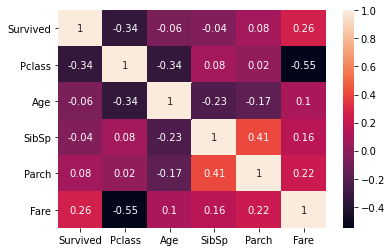

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = df_train2.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()
# categorical features excluded


In [63]:
def printHeatmap(df):
    matrix = df.corr().round(2)
    sns.heatmap(matrix, annot=True)
    plt.show()

In [100]:
# Reference: https://www.kaggle.com/code/sergioortiz/titanic-competition-data-exploration-1/notebook
def multipleReplace(text, wordDic):
    for key in wordDic:
        if text.lower()==key.lower():
            text=wordDic[key]
            break
    return text

def normaliseTitle(title):
    wordDic = {
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Mrs':'Mrs',
    'Master':'Master',
    'Mme': 'Mrs',
    'Lady': 'Nobility',
    'Countess': 'Nobility',
    'Capt': 'Army',
    'Col': 'Army',
    'Dona': 'Other',
    'Don': 'Other',
    'Dr': 'Other',
    'Major': 'Army',
    'Rev': 'Other',
    'Sir': 'Other',
    'Jonkheer': 'Other',
    }     
    title=multipleReplace(title,wordDic)
    return title

def extractTitleFromName(name):
    pos_point=name.find('.')
    if pos_point == -1: return ""
    wordList=name[0:pos_point].split(" ")
    if len(wordList)<=0: return ""
    title=wordList[len(wordList)-1]
    normalisedTitle=normaliseTitle(title)
    return normalisedTitle

# Get a list with different titles
titleList=(df_train_o['Name'].apply(lambda x: extractTitleFromName(x)))
df_train2['title'] = titleList

In [102]:
df_train2

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,title
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,1,1,female,35.0,1,0,113803,53.1000,S,Mrs
4,0,3,male,35.0,0,0,373450,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,S,Other
887,1,1,female,19.0,0,0,112053,30.0000,S,Miss
888,0,3,female,28.0,1,2,W./C. 6607,23.4500,S,Miss
889,1,1,male,26.0,0,0,111369,30.0000,C,Mr


In [103]:
enc = preprocessing.OrdinalEncoder()
arr3 = enc.fit_transform(df_train2)

cols = ['Survived','Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Embarked','title']

df_train3 = pd.DataFrame(arr3, columns=cols)
df_train3

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,title
0,0.0,2.0,1.0,28.0,1.0,0.0,523.0,18.0,2.0,3.0
1,1.0,0.0,0.0,51.0,1.0,0.0,596.0,207.0,0.0,4.0
2,1.0,2.0,0.0,34.0,0.0,0.0,669.0,41.0,2.0,2.0
3,1.0,0.0,0.0,47.0,1.0,0.0,49.0,189.0,2.0,4.0
4,0.0,2.0,1.0,47.0,0.0,0.0,472.0,43.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,1.0,35.0,0.0,0.0,101.0,85.0,2.0,6.0
887,1.0,0.0,0.0,24.0,0.0,0.0,14.0,153.0,2.0,2.0
888,0.0,2.0,0.0,36.0,1.0,2.0,675.0,131.0,2.0,2.0
889,1.0,0.0,1.0,34.0,0.0,0.0,8.0,153.0,0.0,3.0


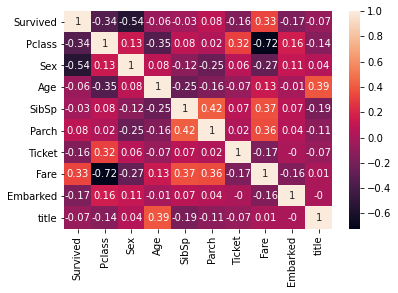

In [104]:
matrix = df_train3.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

#### SibSp has lowest correlation with Survived
#### Sex and Fare, Pclass are higher 
#### Pclass has high relationship with Fare

### Add more features

In [85]:
df_train3['IsAlone']=(df_train3["SibSp"]+df_train3["Parch"]).apply(lambda x: 0 if x>0 else 1)
df_train3['FamilySize']=df_train3["SibSp"]+df_train3["Parch"]+1
df_train3['hasSibSp']=(df_train3["SibSp"]).apply(lambda x: 1 if x>0 else 0)
df_train3['hasParch']=(df_train3["Parch"]).apply(lambda x: 1 if x>0 else 0)

In [98]:
df_train3

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,IsAlone,hasSibSp,hasParch
0,0.0,2.0,1.0,28.0,523.0,18.0,2.0,0,1,0
1,1.0,0.0,0.0,51.0,596.0,207.0,0.0,0,1,0
2,1.0,2.0,0.0,34.0,669.0,41.0,2.0,1,0,0
3,1.0,0.0,0.0,47.0,49.0,189.0,2.0,0,1,0
4,0.0,2.0,1.0,47.0,472.0,43.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,1.0,35.0,101.0,85.0,2.0,1,0,0
887,1.0,0.0,0.0,24.0,14.0,153.0,2.0,1,0,0
888,0.0,2.0,0.0,36.0,675.0,131.0,2.0,0,1,1
889,1.0,0.0,1.0,34.0,8.0,153.0,0.0,1,0,0


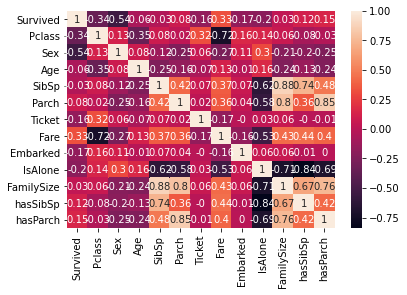

In [87]:
printHeatmap(df_train3)

In [91]:
df_train3 = df_train3.drop(columns=['SibSp', 'Parch', 'FamilySize'])

## Model training

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.model_selection import cross_val_score

In [20]:
dtc = DecisionTreeClassifier(random_state=12)

rfc = RandomForestClassifier(random_state=12)

nn = MLPClassifier(solver='lbfgs', alpha=1,hidden_layer_sizes=(15,), random_state=1)

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0)

In [92]:
y = df_train3['Survived']
X = df_train3.drop(columns=['Survived'])

In [93]:
print(X.shape)
print(y.shape)

(891, 9)
(891,)


#### Decision Tree Classifier

In [69]:
cross_val_score(dtc, X, y, cv=4)

array([0.76233184, 0.77578475, 0.77130045, 0.79279279])

#### Random Forest Classifier

In [62]:
cross_val_score(rfc, X, y, cv=4)# added familysize, isAlone

array([0.77130045, 0.82959641, 0.83408072, 0.86486486])

In [70]:
cross_val_score(rfc, X, y, cv=4)# added isAlone only

array([0.76233184, 0.83856502, 0.81165919, 0.85135135])

In [90]:
cross_val_score(rfc, X, y, cv=4) # added familysize, isAlone, hasSibSp, hasParch

array([0.78026906, 0.82959641, 0.8206278 , 0.83333333])

In [94]:
cross_val_score(rfc, X, y, cv=4) # added isAlone, hasSibSp, hasParch (removed SibSp, Parch)

array([0.77578475, 0.83408072, 0.80717489, 0.84684685])

#### Neural Network

In [76]:
cross_val_score(nn, X, y, cv=4)

F:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
F:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
F:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

array([0.70852018, 0.77130045, 0.78026906, 0.78378378])

#### Pipeline for test.csv

In [77]:
df_test = df_test_o.drop(columns=['PassengerId', 'Cabin','Name'])
values = {"Embarked": 'S', "Age": 28}
df_test2 = df_test.fillna(value=values)

arr3 = enc.fit_transform(df_test2)

cols = ['Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Embarked']

df_test3 = pd.DataFrame(arr3, columns=cols)
df_test3['IsAlone']=(df_test3["SibSp"]+df_test3["Parch"]).apply(lambda x: 0 if x>0 else 1)
df_test3['FamilySize']=df_test3["SibSp"]+df_test3["Parch"]+1
df_test3

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,IsAlone,FamilySize
0,2.0,1.0,44.0,0.0,0.0,152.0,24.0,1.0,1,1.0
1,2.0,0.0,60.0,1.0,0.0,221.0,5.0,2.0,0,2.0
2,1.0,1.0,74.0,0.0,0.0,73.0,41.0,1.0,1,1.0
3,2.0,1.0,34.0,0.0,0.0,147.0,34.0,2.0,1,1.0
4,2.0,0.0,27.0,1.0,1.0,138.0,46.0,2.0,0,3.0
...,...,...,...,...,...,...,...,...,...,...
413,2.0,1.0,35.0,0.0,0.0,267.0,31.0,2.0,1,1.0
414,0.0,0.0,51.0,0.0,0.0,324.0,154.0,0.0,1,1.0
415,2.0,1.0,50.0,0.0,0.0,346.0,9.0,2.0,1,1.0
416,2.0,1.0,35.0,0.0,0.0,220.0,31.0,2.0,1,1.0


In [78]:
df_train3

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,IsAlone,FamilySize
0,0.0,2.0,1.0,28.0,1.0,0.0,523.0,18.0,2.0,0,2.0
1,1.0,0.0,0.0,51.0,1.0,0.0,596.0,207.0,0.0,0,2.0
2,1.0,2.0,0.0,34.0,0.0,0.0,669.0,41.0,2.0,1,1.0
3,1.0,0.0,0.0,47.0,1.0,0.0,49.0,189.0,2.0,0,2.0
4,0.0,2.0,1.0,47.0,0.0,0.0,472.0,43.0,2.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,1.0,35.0,0.0,0.0,101.0,85.0,2.0,1,1.0
887,1.0,0.0,0.0,24.0,0.0,0.0,14.0,153.0,2.0,1,1.0
888,0.0,2.0,0.0,36.0,1.0,2.0,675.0,131.0,2.0,0,4.0
889,1.0,0.0,1.0,34.0,0.0,0.0,8.0,153.0,0.0,1,1.0


In [79]:
df_test3.loc[df_test3['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,IsAlone,FamilySize
152,2.0,1.0,72.0,0.0,0.0,239.0,NaN,2.0,1,1.0


In [80]:

(df_test3.loc[df_test3['Pclass']==2].median())

Pclass          2.0
Sex             1.0
Age            35.0
SibSp           0.0
Parch           0.0
Ticket        204.5
Fare           29.0
Embarked        2.0
IsAlone         1.0
FamilySize      1.0
dtype: float64

In [81]:
df_test3 = df_test3.fillna({"Fare": 29})

In [82]:
rfc.fit(X, y)
y_pred = rfc.predict(df_test3)

In [83]:
df_test_o

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [84]:
def csvTransformer(df_test_o, y_pred):
    df = pd.DataFrame()
    df['PassengerId'] = df_test_o['PassengerId']
    df['Survived'] = y_pred
    
    df.to_csv('prediction2.csv', index=False)
    print('Saved')

csvTransformer(df_test_o, y_pred)

Saved


### Drop SibSp

In [26]:
X2 = X.drop(columns=['Ticket','SibSp'])
cross_val_score(rfc, X2, y, cv=4)

array([0.75784753, 0.83408072, 0.82959641, 0.80630631])

But accuracy drops

### Try in both:
SibSp and Parch: Yes/No

### May try in ordinal encoding: 
Embarked, Pclass: (1, 50, 100)
Sex: (1, 100)
Ticket: removal

### Try frequency encoding

In [27]:
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,S
887,1,1,female,19.0,0,0,112053,30.0000,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,S
889,1,1,male,26.0,0,0,111369,30.0000,C


In [28]:
for x in df_train.columns:
    print(df_train[x].value_counts())

0    549
1    342
Name: Survived, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64
